# Implementing and visualising the control optimal gates for propagator realisation

In this program, we take the optimised control gates from _implicit_hamiltonian_simulation_mpo.m_ and visualise them and, where possible, implement them using a state vector simulation with QuTiP. 

We are aiming to realise time evolution generated by the Heisenberg Hamiltonian using simpler control operators. One immediate issue that arose concerned the reachability of the Heisenberg operators. We require that the full Lie algebra associated with the control operators contain the target Hamiltonian terms, and unfortunately the transverse field Ising interactions, $\{X_j, Z_k Z_{k + 1}\}_{j \in [1, n], k \in [1, n-1]}$ do not generate the $\{X_k X_{k+1}\}$ terms. We can introduce an additional $\{Y_j\}$ or $\{Z_j\}$ to the control to make the set universal, but then we generate the full $4^n$ dimensional Lie algebra which limits the number of qubits we can work with. If we can find a reasonable and non-universal set of control operators that generate $\{X_k X_{k+1}, Y_k Y_{k+1}, Z_k Z_{k+1}\}$ then this would be very good. For example, choosing $\{X_j, X_k X_{k+1}, Z_k Z_{k+1}\}$ gives a Lie algebra of $2^n$, but means we have to experimentally be able to implement $XX$ interactions. Is this reasonable?

Alternatively, we could look at diffucult but interesting Hamiltonian's with generators contained in the Lie algebra of the control operators. 

In [1]:
#importing packages and modules
import numpy as np
import random
import itertools
import time
from matplotlib import pyplot as plt
from qutip import *

from pauli_string_functions_module_python import *

In [2]:
#Lie algebra of control terms
n = 4
Hc_set = tuple(list(all_single_operator_strings(n, 'X')) + list(local_2body_strings(n, 'ZZ')))
lie_algebra = closed_A_set_func(Hc_set, Hc_set)

In [21]:
len(lie_algebra)

66

In [18]:
#importing data 
n = 4
T_optm = 12.5664
c1q_Pauli_strings = all_single_operator_strings(n, 'X')
c2q_Pauli_strings = local_2body_strings(n, 'ZZ')
c1q_binned = np.loadtxt('c1q_binned_run_1.txt', delimiter = ',')
c2q_binned = np.loadtxt('c2q_binned_run_1.txt', delimiter = ',')
num_bins = len(c1q_binned[:, 0])
Dt = T_optm / num_bins



#ALWAYS CHECK T_OPTM

In [19]:
#organising data into coefficients for mesolve
time_steps = 10000
times = np.linspace(0, T_optm, time_steps)

c1q_coeff = np.zeros([time_steps, n])
for j in range(n):
    count = 1
    for i in range(time_steps):
        if times[i] > count * Dt:
            count += 1
        c1q_coeff[i, j] = c1q_binned[count - 1, j]

c2q_coeff = np.zeros([time_steps, n - 1])
for j in range(n - 1):
    count = 1
    for i in range(time_steps):
        if times[i] > count * Dt:
            count += 1
        c2q_coeff[i, j] = c2q_binned[count - 1, j]


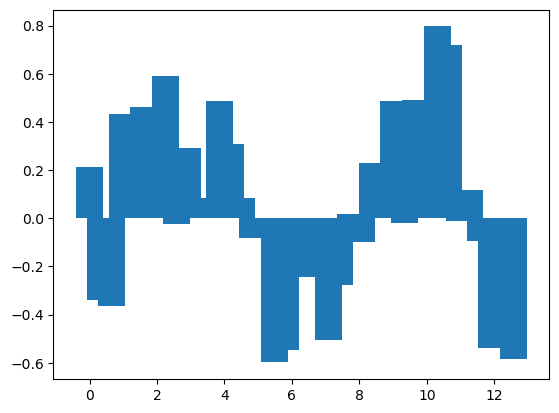

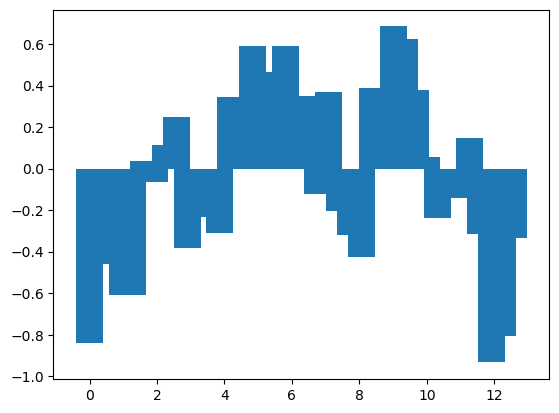

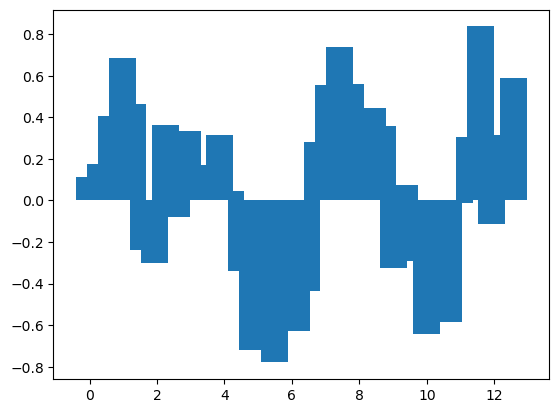

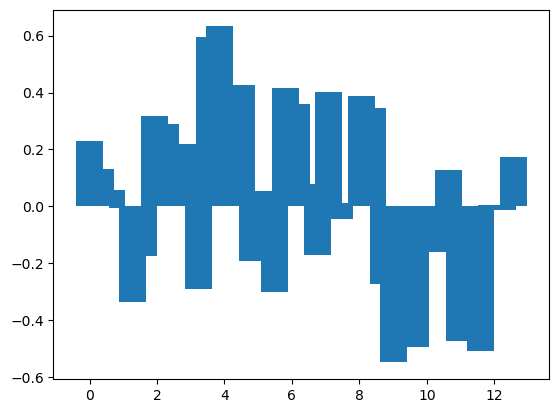

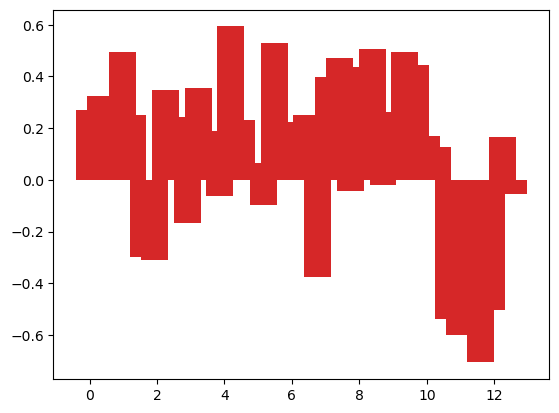

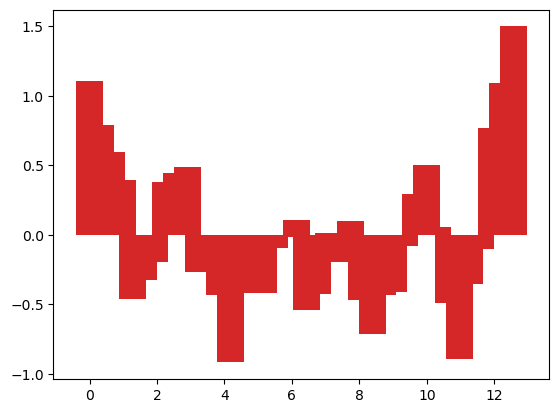

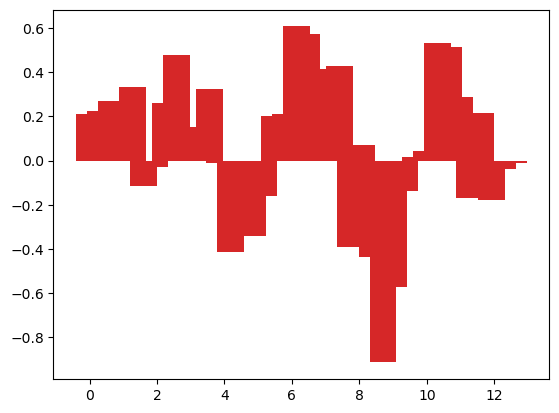

In [20]:
#plotting the gate sequence
times_binned = np.linspace(0, T_optm, num_bins)
for i in range(n):
    plt.bar(times_binned, c1q_binned[:, i], color = 'tab:blue')
    plt.show()
for i in range(n - 1):
    plt.bar(times_binned, c2q_binned[:, i], color = 'tab:red')
    plt.show()

In [21]:
#simulating the target evolution acting on a state
time_dependent_control_Hamiltonian = []

c1q_ops = []
for P_str in c1q_Pauli_strings:
    c1q_ops.append(operator_string_from_Pauli_string(P_str))

c2q_ops = []
for P_str in c2q_Pauli_strings:
    c2q_ops.append(operator_string_from_Pauli_string(P_str))
c2q_ops

c1q_time_dependence = np.zeros(n, dtype = list)
for i in range(n):
    c1q_time_dependence[i] = [c1q_ops[i], c1q_coeff[:, i]]

c2q_time_dependence = np.zeros(n - 1, dtype = list)
for i in range(n - 1):
    c2q_time_dependence[i] = [c2q_ops[i], c2q_coeff[:, i]]
c2q_time_dependence[2]

H_control = list(np.append(c1q_time_dependence, c2q_time_dependence))

In [34]:
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)])
result = mesolve(H_control, psi0, times)

In [35]:
n = 4
target_Pauli_strings = tuple(list(local_2body_strings(n, 'YY')) + list(local_2body_strings(n, 'ZZ')))
target_T_evol = 1
target_times = np.linspace(0, target_T_evol, time_steps)
target_Hamiltonian = 0
for P_str in target_Pauli_strings:
    target_Hamiltonian += operator_string_from_Pauli_string(P_str)
target_result = sesolve(target_Hamiltonian, psi0, target_times)


In [36]:
control_state = result.states[-1]
target_state = target_result.states[-1]
fidelity(control_state, target_state)
#fidelity is very poor, ESPECIALLY when the initial state includes a 1
#eg; fidelity = 33% for |000000> but down to 5% for |100000>
#WHY IS THIS!!!

0.08119497603336893